In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import cis
from glob import glob
# import xarray as xr
from cis.data_io.gridded_data import make_from_cube
import matplotlib.pyplot as plt
from cartopy import crs as ccrs
import matplotlib.patches as patch
import iris
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.patches as patch
import numpy as np
import cartopy.crs as ccrs
from cis.data_io.gridded_data import make_from_cube

In [2]:
#Calculates the albedo difference for the main result of the report



In [3]:
#read in ISCCP data
import os.path

mean_file = "isccp_mean_sams_method.nc"

if os.path.isfile(mean_file):
# This is basically identical to my straight mean so I'm not sure why he does this...
    isccp_mean = iris.load_cube(mean_file)
else:
    def load_callback(cube, field, fname):
        variable_attributes = ['date_metadata_modified', 'date_issued', 'date_modified', 'date_created',
                               'isccp_input_files', 'time_coverage_start', 'time_coverage_end', 'isccp_month', 'id',
                               'history']
        for a in variable_attributes:
            cube.attributes.pop(a)

    months=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    directory = 'F:\\Local Data//isccp-h-series/'
    filelist = glob(directory+'ISCCP-Basic*GLOBAL*0'+'*99.9999*')
    c = iris.load(filelist[0], iris.Constraint(cube_func=lambda x:
        x.var_name=='cldamt_types'), callback=load_callback).concatenate_cube()[:,1,...]



    counts = make_from_cube(c).make_new_with_same_coordinates(data=None, var_name='mean_strat', standard_name='mean_strat',
                                           long_name='mean_stratocumulus', history='what', units='1',
                                            flatten=False)
    temp_counts = make_from_cube(c).make_new_with_same_coordinates(data=None, var_name='mean_strat', standard_name='mean_strat',
                                           long_name='mean_stratocumulus', history='what', units='1',
                                            flatten=False)
    sums = make_from_cube(c).make_new_with_same_coordinates(data=None, var_name='mean_strat', standard_name='mean_strat',
                                           long_name='mean_stratocumulus', history='what', units='percent',
                                            flatten=False)

    #convert from masked array to array with zeros so can add them together and keep data, then convert back to masked at the end so that the plotting works nicely
    no = 0
    for filename in filelist[1:]:

        c = (iris.load(filename, iris.Constraint(cube_func=lambda x:
            x.var_name=='cldamt_types'), callback=load_callback).concatenate_cube())[:,1,...]
        temp_counts.data = 1-np.ma.getmask(c.data).astype('uint16')
        c.data=np.ma.filled(c.data, fill_value=0)

        sums += c
        counts += temp_counts

        no += 1
        print(no+1, ' of ', len(filelist), ' done')

    #Relevant arrays
    isccp_mean = make_from_cube(sums/counts)

    # This is basically identical to my straight mean so I'm not sure why he does this...
    isccp_mean.save_data(mean_file)


In [4]:
isccp_mean = iris.load_cube('average_cldamt.nc')[:, 1, ...]

In [5]:
#read in POC data
dataDIR = './density_data/*count*'
filelist = glob(dataDIR)
counts=[]
for file in filelist:
    counts.append(cis.read_data(file, 'poc_mask_num_points'))
total_counts = make_from_cube(sum(counts))

dataDIR = './density_data/*sum*'
filelist = glob(dataDIR)
sums=[]
for file in filelist:
    d=cis.read_data(file, 'poc_mask')
#     print(d.data.max())
    sums.append(d)
total_sum = make_from_cube(sum(sums)/255) #mask is uint8

# 25582 <- total number of tiles?
# 1992 <- Subset of POCs???
all_files_counts = total_counts*(25582/1992)
#  This turns the total counts (from this subset) in to a more representitive total counts

# 4729 <- Total number of POCs detected
# This turns it into a per year quantity?
total_sum=total_sum*(4729/1992)
#  This turns the total sum (from this subset) in to a more representitive total counts

density = make_from_cube(total_sum/all_files_counts)
density.data = np.ma.masked_where(total_sum.data<10, density.data)

albedo_effect = make_from_cube(isccp_mean).make_new_with_same_coordinates(data=None, var_name='mean_strat', standard_name='mean_strat',
                                       long_name='mean_stratocumulus', history='what', units='percent',
                                        flatten=False)

#longitude coordinates different for poc data vs isccp so align the arrays (one runs from 0 to 360, the other -180 to 180):
aligned_density = make_from_cube(isccp_mean).make_new_with_same_coordinates(data=None, var_name='mean_strat', standard_name='mean_strat',
                                       long_name='mean_stratocumulus', history='what', units='percent',
                                        flatten=False)
data = np.zeros((1,180,360))
mask = np.zeros((1,180,360))
data[0,:,0:180] = density.data[:,180:360,0]
data[0,:,180:360] = density.data[:,0:180,0]
mask[0,:,0:180] = np.ma.getmask(density.data)[:,180:360,0]
mask[0,:,180:360] = np.ma.getmask(density.data)[:,0:180,0]

# This (probably is) accounts for false negatives (and false positives?)
detection_rate_factor = 1.734 #|1/(precision*recall)
aligned_density.data = np.ma.MaskedArray(data*detection_rate_factor, mask)
# aligned_density *= detection_rate_factor
# new_mask = np.ma.masked_where(all_files_counts.data<10000, aligned_density)

# total_sum.copy(np.ma.masked_where(total_counts.data<10000, total_sum.data/total_counts.data))

normalised_density = make_from_cube(aligned_density*100/isccp_mean)

C:\Users\duncan\miniconda3\envs\cis_env3\lib\site-packages\iris\__init__.py:249: IrisDeprecation: setting the 'Future' property 'netcdf_promote' is deprecated and will be removed in a future release. Please remove code that sets this property.
  warn_deprecated(msg.format(name))
C:\Users\duncan\miniconda3\envs\cis_env3\lib\site-packages\iris\__init__.py:249: IrisDeprecation: setting the 'Future' property 'netcdf_promote' is deprecated and will be removed in a future release. Please remove code that sets this property.
  warn_deprecated(msg.format(name))
C:\Users\duncan\miniconda3\envs\cis_env3\lib\site-packages\iris\__init__.py:249: IrisDeprecation: setting the 'Future' property 'netcdf_promote' is deprecated and will be removed in a future release. Please remove code that sets this property.
  warn_deprecated(msg.format(name))
C:\Users\duncan\miniconda3\envs\cis_env3\lib\site-packages\iris\__init__.py:249: IrisDeprecation: setting the 'Future' property 'netcdf_promote' is deprecated a

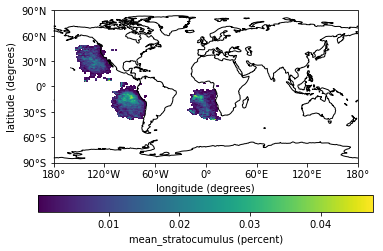

In [6]:
aligned_density.plot()

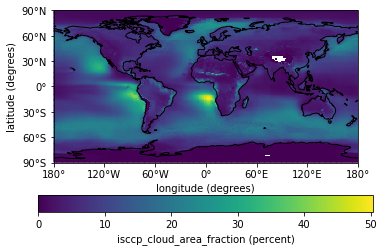

In [7]:
isccp_mean.plot()

In [8]:
aligned_density.data = aligned_density.data.filled(0.)

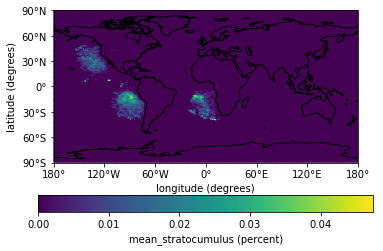

In [9]:
aligned_density.plot()

In [15]:
# These come from the Edington approximation based on the mean POC properties - see contour_plotter...py
# open_cell_albedo = 0.3749
# closed_cell_albedo = 0.5045

open_cell_albedo =.330
closed_cell_albedo =.49

albedo_difference = open_cell_albedo-closed_cell_albedo

albedo_assuming_closed_cell = make_from_cube(closed_cell_albedo*isccp_mean/100.)
mean_albedo_assuming_closed_cell, _, _ = make_from_cube(albedo_assuming_closed_cell).collapsed(isccp_mean.coords())

## This is the actual calcultion
albedo_including_pocs = (open_cell_albedo*aligned_density + closed_cell_albedo*(1-aligned_density.data))*isccp_mean/100
mean_albedo_including_pocs, _, _ = make_from_cube(albedo_including_pocs).collapsed(albedo_including_pocs.coords())

C:\Users\duncan\miniconda3\envs\cis_env3\lib\site-packages\iris\analysis\cartography.py:394: UserWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn("Using DEFAULT_SPHERICAL_EARTH_RADIUS.")
C:\Users\duncan\miniconda3\envs\cis_env3\lib\site-packages\iris\analysis\cartography.py:394: UserWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn("Using DEFAULT_SPHERICAL_EARTH_RADIUS.")


In [16]:
mean_albedo_assuming_closed_cell.data

array(0.05036536)

In [17]:
mean_albedo_including_pocs.data

array(0.05033892)

In [18]:
350 * mean_albedo_including_pocs.data

17.61862337870531

In [19]:
350*(mean_albedo_assuming_closed_cell.data - mean_albedo_including_pocs.data)

0.009253391627091212

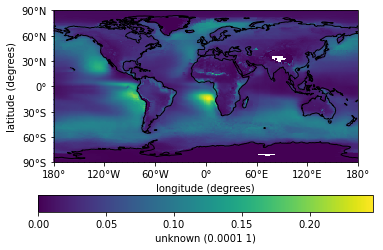

In [19]:
albedo_including_pocs.plot()

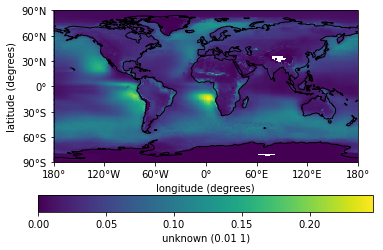

In [20]:
albedo_assuming_closed_cell.plot()

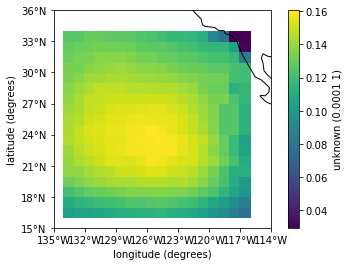

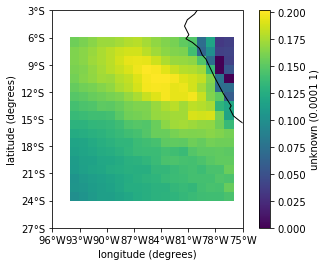

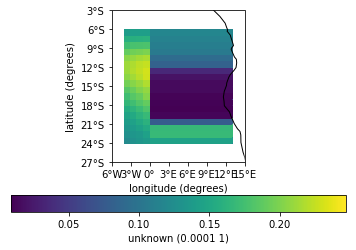

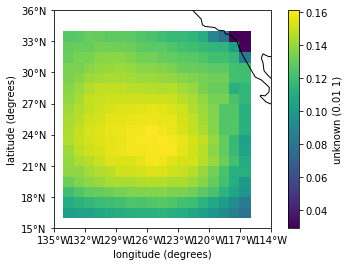

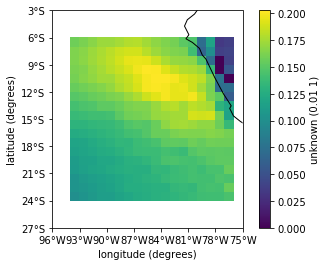

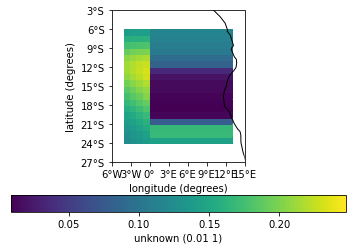

In [14]:
# The below calculates this regionally

#lon = {'cal':[205,265], 'per':[240,305], 'nam':[335,35]}
#lat = {'cal':[10,55], 'per':[-45,10], 'nam':[-45,15]}
lon = {'cal':[225,245], 'per':[265,285], 'nam':[355,15]}
lat = {'cal':[15,35], 'per':[-25,-5], 'nam':[-25,-5]}

albedos_with_pocs = []
names = []
for key, value in lon.items():
        if key == 'nam':
            sub = albedo_including_pocs.extract(iris.Constraint(longitude=lambda cell: cell > lon[key][0] or cell < lon[key][1]) & #cal: 230 240, per: 270 280, nam: 0 10
                iris.Constraint(latitude=lambda cell: lat[key][0] < cell < lat[key][1]))
        else:
            sub = albedo_including_pocs.extract(iris.Constraint(longitude=lambda cell: lon[key][0] < cell < lon[key][1]) & #cal: 230 240, per: 270 280, nam: 0 10
                iris.Constraint(latitude=lambda cell: lat[key][0] < cell < lat[key][1])) #cal: 20 30, per: -20 -10, nam: -20 -10

        albedos_with_pocs.append(np.nanmean(sub.data))
        names.append(key)
        make_from_cube(sub).plot()


albedos_closed_cells = []
for key, value in lon.items():
        if key == 'nam':
            sub = albedo_assuming_closed_cell.extract(iris.Constraint(longitude=lambda cell: cell > lon[key][0] or cell < lon[key][1]) & #cal: 230 240, per: 270 280, nam: 0 10
                iris.Constraint(latitude=lambda cell: lat[key][0] < cell < lat[key][1]))
        else:
            sub = albedo_assuming_closed_cell.extract(iris.Constraint(longitude=lambda cell: lon[key][0] < cell < lon[key][1]) & #cal: 230 240, per: 270 280, nam: 0 10
                iris.Constraint(latitude=lambda cell: lat[key][0] < cell < lat[key][1])) #cal: 20 30, per: -20 -10, nam: -20 -10

        albedos_closed_cells.append(np.nanmean(sub.data))
        make_from_cube(sub).plot()

In [15]:
albedos_with_pocs

[0.1337877792563033, 0.14677026045442984, 0.16676823440638977]

In [16]:
albedos_closed_cells

[0.13422067, 0.14762764, 0.16706279]